In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.transforms import Resize

from tqdm import tqdm
import imageio
import gc

In [2]:
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=128, stride=2) # 256
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=128, stride=2) # 512
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128*ResBlock.expansion, num_classes) # 512
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

def some_model(num_classes, channels):
    return ResNet(Bottleneck, [2,3,3,2], num_classes, channels)

In [3]:
cfg = dict()
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 6
cfg['dropout'] = 0.2
cfg['fc_intermediate_len'] = 100 # ? 128
cfg['x_size'] = 150 # ? such order of dims
cfg['y_size'] = 300 # ? such order of dims

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = '../input/bms-molecular-translation/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') )

In [6]:
# For multiple target regression
class PretrainRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file, y_file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        
        # choosing atoms C, N, O, F, S, Cl
        y  = np.zeros((self.data.shape[0], cfg['output_channels'])) # output_channels=6
        y[:,:4] = np.load(y_file)[:,1:5]
        y[:,4] = np.load(y_file)[:,7]
        y[:,5] = np.load(y_file)[:,8]
        
        self.y = torch.tensor(y, dtype=torch.float32)#.unsqueeze(1)
        self.y.to(device)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        y = self.y[index,:]
        return pic, y

In [7]:
dataset_train = PretrainRegressionDataset('../input/data-from-laptop/data_train_medium.csv',
                                          '../input/data-from-laptop/atom_counts_train_medium.npy',
                                           x_size=cfg['x_size'], y_size=cfg['y_size'])
dataset_test = PretrainRegressionDataset('../input/data-from-laptop/data_test_medium.csv',
                                         '../input/data-from-laptop/atom_counts_test_medium.npy',
                                          x_size=cfg['x_size'], y_size=cfg['y_size'])

In [8]:
x, y = dataset_train[5]
print(y)
del x
del y

tensor([20.,  4.,  5.,  2.,  0.,  0.])


In [9]:
def calc_loss(cnn, data_loader, loss_type='mse'):
    if loss_type == 'mae':
        Loss = nn.L1Loss(reduction='sum')
    else:
        print('ERROR')
        return float('+inf')

    loss = 0.0
    count = 0
    cnn.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = cnn(x_batch)
            loss += Loss(predictions, y_batch).item()
            count += y_batch.shape[0] # * y_batch.shape[1]
    return loss / count

In [10]:
def train_epoch(data_loader, cnn, optimizer, criterion):
    running_loss = 0.0
    for x_batch, y_batch in tqdm(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss

In [11]:
def train_model(dataset_train, dataset_test, cnn, n_epochs, batch_size, history):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=4, persistent_workers=False,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2,pin_memory=False)

    #criterion = nn.MSELoss()
    #criterion = nn.L1Loss()
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_loss = train_epoch(data_train_loader, cnn, optimizer, criterion)
        
        print('Train running loss (L1Smooth):\t', train_loss)
        train_loss = calc_loss(cnn, data_train_loader, 'mae')
        test_loss  = calc_loss(cnn, data_test_loader,  'mae')
        print('Train loss (MAE):\t', train_loss)
        print('Test  loss (MAE):\t', test_loss)
        history.append((train_loss, test_loss))
        torch.save(resnet.state_dict(), './resnet_multiple_epoch_{}.model'.format(i))

In [29]:
def train_model_finetune(dataset_train, dataset_test, cnn, n_epochs, batch_size, history):
    data_train_loader = torch.utils.data.DataLoader(dataset_train, batch_size,
                                                   num_workers=4, persistent_workers=False,pin_memory=True)
    data_test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size, num_workers=2,pin_memory=False)

    #criterion = nn.MSELoss()
    #criterion = nn.L1Loss()
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00002)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        cnn.train()
        train_loss = train_epoch(data_train_loader, cnn, optimizer, criterion)
        
        print('Train running loss (L1Smooth):\t', train_loss)
        train_loss = calc_loss(cnn, data_train_loader, 'mae')
        test_loss  = calc_loss(cnn, data_test_loader,  'mae')
        print('Train loss (MAE):\t', train_loss)
        print('Test  loss (MAE):\t', test_loss)
        history.append((train_loss, test_loss))
        torch.save(resnet.state_dict(), './resnet_multiple_epoch_{}_finetune.model'.format(i))

In [12]:
resnet = some_model(cfg['output_channels'], channels=1)
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
history = []

Start computations with n_epochs=3 (after that loss grows).

In [15]:
%%time
train_model(dataset_train, dataset_test, resnet, n_epochs=6, batch_size=200, history=history)

Starting epoch 0

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [04:02<00:00,  1.65it/s]

Train running loss (L1Smooth):	 453.95486706495285



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 5.766978346252442
Test  loss (MAE):	 5.778751611328125
Starting epoch 1


100%|██████████| 400/400 [04:01<00:00,  1.65it/s]

Train running loss (L1Smooth):	 149.61307941377163



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 3.6608077392578124
Test  loss (MAE):	 3.6821674255371093
Starting epoch 2


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train running loss (L1Smooth):	 85.72798155248165



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 2.5485434230804445
Test  loss (MAE):	 2.600287065124512
Starting epoch 3


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train running loss (L1Smooth):	 58.714220337569714



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 2.622013196563721
Test  loss (MAE):	 2.674169024658203
Starting epoch 4


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train running loss (L1Smooth):	 41.921929340809584



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 2.1625573780059812
Test  loss (MAE):	 2.2332023529052734
Starting epoch 5


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train running loss (L1Smooth):	 34.2354280538857


Train loss (MAE):	 2.2666586631774903
Test  loss (MAE):	 2.3315100982666017
CPU times: user 26min 45s, sys: 1min 8s, total: 27min 53s
Wall time: 42min 55s


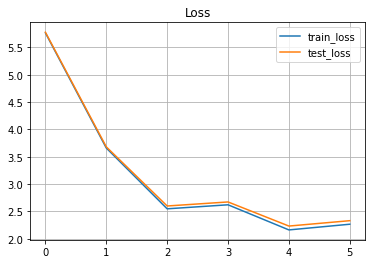

In [25]:
x = np.arange(len(history))
history_np = np.zeros((len(history), 2))
for index, elem in enumerate(history):
    history_np[index, 0], history_np[index, 1] = elem[0], elem[1]
plt.plot(x, history_np[:,0], x, history_np[:,1])
plt.legend(['train_loss', 'test_loss'])
plt.title('Loss')
plt.grid(True)
plt.savefig('fig1.png')
plt.show()

In [17]:
preds = [None] * 10
trues = []
resnet.eval()
for index, (_, __) in enumerate(dataset_test):
    if index > 0:
        break
    print(__)
    with torch.no_grad():
        pred = np.round(resnet(_.unsqueeze(0).to(device)).to(torch.device('cpu')).numpy(), 2)
        print(pred)

tensor([20.,  0.,  5.,  0.,  0.,  0.])
[[ 2.33e+01  1.25e+00  3.67e+00  1.00e-01 -2.00e-02 -1.30e-01]]


In [18]:
torch.save(resnet.state_dict(), 'data/resnet_multiple_v1.model')

In [31]:
resnet = some_model(cfg['output_channels'], channels=1)
resnet.load_state_dict(torch.load('./resnet_multiple_epoch_5.model'))
resnet.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [28]:
resnet.eval()
_, __ = dataset_test[5]
print(__)
with torch.no_grad():
    pred = np.round(resnet(_.unsqueeze(0).to(device)).to(torch.device('cpu')).numpy(), 2)
    print(pred)

tensor([26.,  2.,  4.,  0.,  1.,  1.])
[[26.22  1.65  4.57  0.07  0.8   0.8 ]]


## Continue training model with smaller step.

In [32]:
%%time
history = []
train_model_finetune(dataset_train, dataset_test, resnet, n_epochs=5, batch_size=200, history=history)

  0%|          | 0/400 [00:00<?, ?it/s]

Starting epoch 0


100%|██████████| 400/400 [04:02<00:00,  1.65it/s]

Train running loss (L1Smooth):	 25.730646532028913



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 1.0005799310684205
Test  loss (MAE):	 1.1503757469177247
Starting epoch 1


100%|██████████| 400/400 [04:01<00:00,  1.65it/s]

Train running loss (L1Smooth):	 23.727816831320524



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 0.979543825340271
Test  loss (MAE):	 1.1413592300415039
Starting epoch 2


100%|██████████| 400/400 [04:02<00:00,  1.65it/s]

Train running loss (L1Smooth):	 22.281344264745712



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 0.9017130914688111
Test  loss (MAE):	 1.0895325241088867
Starting epoch 3


100%|██████████| 400/400 [04:01<00:00,  1.65it/s]

Train running loss (L1Smooth):	 21.051871238276362



  0%|          | 0/400 [00:00<?, ?it/s]

Train loss (MAE):	 0.8772111429214478
Test  loss (MAE):	 1.0770070693969727
Starting epoch 4


100%|██████████| 400/400 [04:01<00:00,  1.66it/s]

Train running loss (L1Smooth):	 19.966566760092974


Train loss (MAE):	 0.8613960321426392
Test  loss (MAE):	 1.073634188079834
CPU times: user 22min 13s, sys: 57.9 s, total: 23min 11s
Wall time: 35min 56s


In [33]:
print(history_np)
print(history)

[[5.76697835 5.77875161]
 [3.66080774 3.68216743]
 [2.54854342 2.60028707]
 [2.6220132  2.67416902]
 [2.16255738 2.23320235]
 [2.26665866 2.3315101 ]]
[(1.0005799310684205, 1.1503757469177247), (0.979543825340271, 1.1413592300415039), (0.9017130914688111, 1.0895325241088867), (0.8772111429214478, 1.0770070693969727), (0.8613960321426392, 1.073634188079834)]


**Оставляем последнюю сеть для использования.**

# Applying pretrained model to the test dataset

In [34]:
class TestPicturesDataset(torch.utils.data.Dataset):
    def __init__(self, file, x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index], is_train=False).unsqueeze(0) # C=1 channel
        pic = self.resize(pic) / 255.
        return pic

In [35]:
test_dataset = TestPicturesDataset('../input/bms-molecular-translation/sample_submission.csv')

In [36]:
b_size = 200
test_loader = torch.utils.data.DataLoader(test_dataset, b_size, num_workers=4, 
                                          persistent_workers=False, pin_memory=True)

In [37]:
results = torch.zeros((len(test_dataset), cfg['output_channels']))

In [38]:
resnet.eval()
with torch.no_grad():
    index = 0
    for x_batch in tqdm(test_loader):
        results[index:(index+x_batch.shape[0])] = resnet(x_batch.to(device)).to(torch.device('cpu'))
        index += x_batch.shape[0]
results

100%|██████████| 8081/8081 [1:23:12<00:00,  1.62it/s]


tensor([[ 9.7393,  2.6543,  0.3354,  0.2961,  0.3714,  0.8943],
        [10.6240,  0.2256, -0.3063,  0.4182,  0.1915,  1.4067],
        [13.6446, -0.3628,  0.6235,  0.3445,  0.1192,  0.7409],
        ...,
        [14.9269, -0.2644,  1.8217,  0.3049, -0.1560,  0.6705],
        [12.1062, -0.8509,  2.3375,  0.3415,  0.0774,  0.7525],
        [19.1212,  0.3812,  1.1387,  1.3643, -0.2567,  0.6757]])

In [39]:
np.save('./results_multiple_counts.npy', np.round(results.numpy()).astype(np.int32) )